In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


In [6]:
print(category_lines['English'])

['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel', 'Abraham', 'Abrahams', 'Abrams', 'Ackary', 'Ackroyd', 'Acton', 'Adair', 'Adam', 'Adams', 'Adamson', 'Adanet', 'Addams', 'Adderley', 'Addinall', 'Addis', 'Addison', 'Addley', 'Aderson', 'Adey', 'Adkins', 'Adlam', 'Adler', 'Adrol', 'Adsett', 'Agar', 'Ahern', 'Aherne', 'Ahmad', 'Ahmed', 'Aikman', 'Ainley', 'Ainsworth', 'Aird', 'Airey', 'Aitchison', 'Aitken', 'Akhtar', 'Akram', 'Alam', 'Alanson', 'Alber', 'Albert', 'Albrighton', 'Albutt', 'Alcock', 'Alden', 'Alder', 'Aldersley', 'Alderson', 'Aldred', 'Aldren', 'Aldridge', 'Aldworth', 'Alesbury', 'Alexandar', 'Alexander', 'Alexnader', 'Alford', 'Algar', 'Ali', 'Alker', 'Alladee', 'Allam', 'Allan', 'Allard', 'Allaway', 'Allcock', 'Allcott', 'Alldridge', 'Alldritt', 'Allen', 'Allgood', 'Allington', 'Alliott', 'Allison', 'Allkins', 'Allman', 'Allport', 'Allsop', 'Allum', 'Allwood', 'Almond', 'Alpin', 'Alsop', 'Altham', 'Althoff', 'Alves', 'Alvey', 'Alway', 'Ambrose', 'Amesbury', 'Amin', 'Amner', 'Am

In [8]:
'''
.. NOTE::
역자 주:  One-Hot 벡터는 언어를 다룰 때 자주 이용되며,
단어, 글자 등을 벡터로 표현할 때 단어, 글자 사이의 상관 관계를 미리 알 수 없을 경우,
One-Hot으로 표현하여 서로 직교한다고 가정하고 학습을 시작합니다.
이와 동일하게, 상관 관계를 알 수 없는 다른 데이터의 경우에도 One-Hot 벡터를 활용할 수 있습니다.
'''

import torch

# all_letters 로 문자의 주소 찾기, 예시 "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 검증을 위해서 한 개의 문자를 <1 x n_letters> Tensor로 변환
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 한 줄(이름)을  <line_length x 1 x n_letters>,
# 또는 One-Hot 문자 벡터의 Array로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [10]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [12]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [14]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8542, -2.8226, -2.8673, -2.9743, -2.9070, -2.8688, -2.8388, -3.0256,
         -2.8802, -2.9078, -2.8788, -2.9517, -3.0118, -2.8545, -2.8912, -2.8634,
         -2.8781, -2.7838]], grad_fn=<LogSoftmaxBackward0>)


In [16]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)  # 텐서의 가장 큰 값 및 주소
    category_i = top_i[0].item()   # 텐서에서 정수 값으로 변경
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Vietnamese', 17)


In [18]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Dutch / line = Smeets
category = French / line = Dupont
category = Italian / line = Berardi
category = Russian / line = Tokarenko
category = French / line = Belanger
category = Vietnamese / line = Huynh
category = Vietnamese / line = Chu
category = Irish / line = Hayden
category = Italian / line = Pace
category = Polish / line = Mozdzierz


In [20]:
criterion = nn.NLLLoss()

In [22]:
learning_rate = 0.01  # 학습률을 너무 높게 설정하면 발산할 수 있고, 너무 낮으면 학습이 되지 않을 수 있습니다.

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더합니다.
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [25]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # ``iter`` 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 0.8212 Tao / Vietnamese ✗ (Chinese)
10000 10% (0m 15s) 0.8902 Soares / Portuguese ✓
15000 15% (0m 27s) 0.0946 Garofalis / Greek ✓
20000 20% (0m 38s) 0.2215 Reynders / Dutch ✓
25000 25% (0m 49s) 0.0811 Ferreira / Portuguese ✓
30000 30% (0m 57s) 0.7651 Henriques / Portuguese ✓
35000 35% (1m 6s) 3.9575 Wang / Chinese ✗ (German)
40000 40% (1m 15s) 0.6104 Eggby / English ✓
45000 45% (1m 23s) 0.6976 Pohodin / Russian ✓
50000 50% (1m 31s) 0.9638 Dufort / French ✓
55000 55% (1m 39s) 0.2691 Yap / Chinese ✓
60000 60% (1m 48s) 0.1256 Yu / Korean ✓
65000 65% (1m 55s) 3.2191 Paternoster / German ✗ (French)
70000 70% (2m 3s) 0.8059 Alduino / Italian ✓
75000 75% (2m 10s) 2.3070 Kalb / Scottish ✗ (German)
80000 80% (2m 18s) 2.0720 Watt / Scottish ✗ (English)
85000 85% (2m 25s) 2.2311 Fergus / English ✗ (Irish)
90000 90% (2m 32s) 0.5397 Ferro / Portuguese ✓
95000 95% (2m 39s) 0.8946 Petimezas / Greek ✓
100000 100% (2m 46s) 4.0299 Huang / Vietnamese ✗ (Chinese)


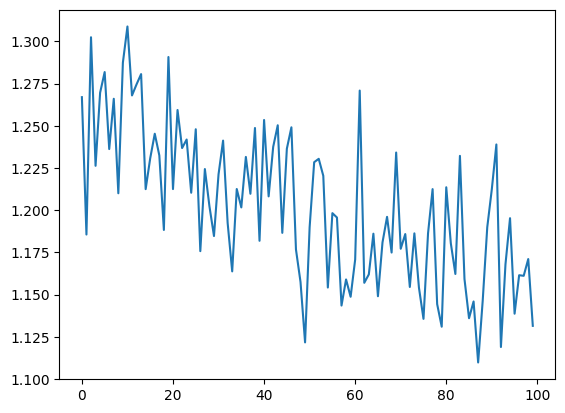

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

C:\Users\user\AppData\Local\Temp\ipykernel_27116\2811754854.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\user\AppData\Local\Temp\ipykernel_27116\2811754854.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


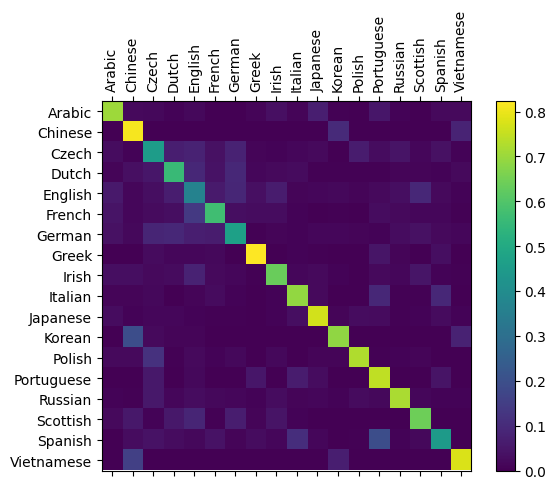

In [28]:
# 혼란 행렬에서 정확한 추측을 추적
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 예시 중 어떤 것이 정확히 예측되었는지 기록
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [29]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.53) Czech
(-1.32) Russian
(-2.23) English

> Jackson
(-0.23) Scottish
(-2.30) English
(-3.06) Czech

> Satoshi
(-1.27) Japanese
(-1.36) Italian
(-2.12) Arabic
